# 데이터 불러오기

In [46]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Sep 15 01:08 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

In [ ]:
!ls -l

total 20
drwx------ 5 root root 4096 Nov  4 03:25 drive
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data
drwxr-xr-x 4 root root 4096 Nov  4 03:25 test
drwxr-xr-x 4 root root 4096 Nov  4 03:25 train
drwxr-xr-x 4 root root 4096 Nov  4 03:25 validation


In [ ]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

# 데이터 증식을 사용하지 않는 빠른 특성 추출

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size]=features_batch
        labels[i * batch_size : (i + 1) * batch_size]=labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.5999 - acc: 0.6665 - val_loss: 0.4510 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4333 - acc: 0.8065 - val_loss: 0.3698 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3600 - acc: 0.8530 - val_loss: 0.3283 - val_acc: 0.8820
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3165 - acc: 0.8700 - val_loss: 0.3029 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2914 - acc: 0.8805 - val_loss: 0.2890 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2722 - acc: 0.8910 - val_loss: 0.2807 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2467 - acc: 0.9085 - val_loss: 0.2681 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

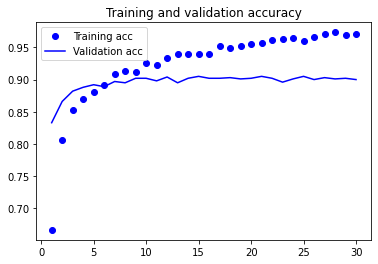

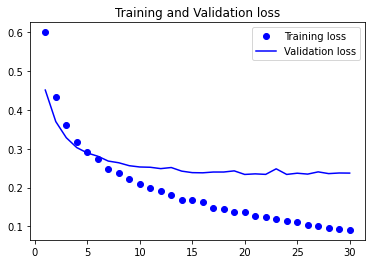

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# 데이터 증식을 사용한 특성 추출

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:',
        len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [ ]:
conv_base.trainable=False
print('conv_base를 동결한 후 훈련되는 가중치의 수:',
        len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=20,
    class_mode = 'binary')

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=2e-5),
              metrics = ['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 26s - loss: 0.5416 - acc: 0.7505 - val_loss: 0.4231 - val_acc: 0.8310
Epoch 2/30
100/100 - 25s - loss: 0.4058 - acc: 0.8390 - val_loss: 0.3457 - val_acc: 0.8700
Epoch 3/30
100/100 - 25s - loss: 0.3629 - acc: 0.8520 - val_loss: 0.3026 - val_acc: 0.8820
Epoch 4/30
100/100 - 25s - loss: 0.3256 - acc: 0.8655 - val_loss: 0.2861 - val_acc: 0.8890
Epoch 5/30
100/100 - 25s - loss: 0.3010 - acc: 0.8805 - val_loss: 0.2795 - val_acc: 0.8900
Epoch 6/30
100/100 - 25s - loss: 0.2971 - acc: 0.8740 - val_loss: 0.2606 - val_acc: 0.8970
Epoch 7/30
100/100 - 25s - loss: 0.2778 - acc: 0.8870 - val_loss: 0.2710 - val_acc: 0.8860
Epoch 8/30
100/100 - 25s - loss: 0.2647 - acc: 0.8935 - val_loss: 0.2559 - val_acc: 0.8990
Epoch 9/30
100/100 - 25s - loss: 0.2572 - acc: 0.8930 - val_loss: 0.2453 - val_acc: 0.9040
Epoch 10/30
100/100 - 25s - loss: 0.2486 - acc: 0.8965 - val_loss: 0.2424 - val_acc: 0.9050
Epoch

# 미세 조정(fine tuning)

In [ ]:
conv_base.trainable=True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block5_conv2':
        set_trainable = True
    if layer.name == 'block5_conv3':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
len(conv_base.trainable_weights)

6

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-5),
              metrics = ['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 29s 263ms/step - loss: 0.1968 - acc: 0.9260 - val_loss: 0.2419 - val_acc: 0.9040
Epoch 2/100
100/100 [==============================] - 26s 261ms/step - loss: 0.1599 - acc: 0.9390 - val_loss: 0.2388 - val_acc: 0.9090
Epoch 3/100
100/100 [==============================] - 26s 259ms/step - loss: 0.1367 - acc: 0.9460 - val_loss: 0.2430 - val_acc: 0.9070
Epoch 4/100
100/100 [==============================] - 26s 259ms/step - loss: 0.1280 - acc: 0.9515 - val_loss: 0.2180 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 26s 259ms/step - loss: 0.1039 - acc: 0.9585 - val_loss: 0.3330 - val_acc: 0.8810
Epoch 6/100
100/100 [==============================] - 26s 259ms/step - loss: 0.0828 - acc: 0.9650 - val_loss: 0.2180 - val_acc: 0.9200
Epoch 7/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0828 - acc: 0.9705 - val_loss: 0.2014 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

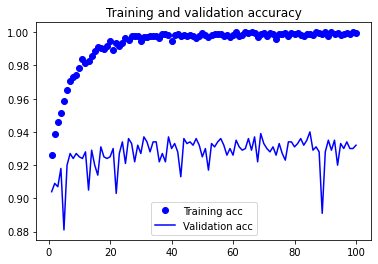

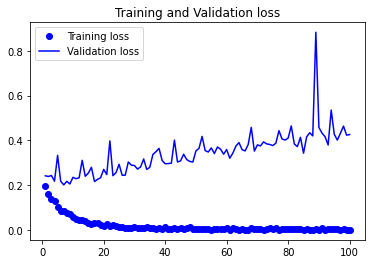

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

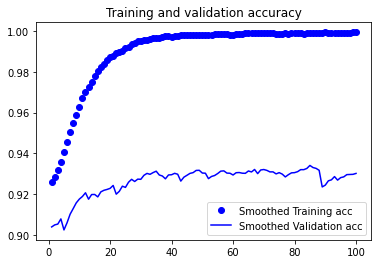

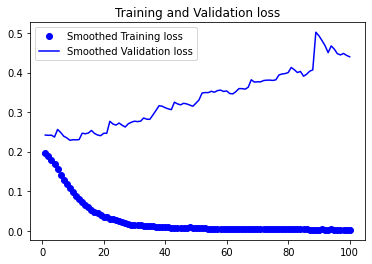

In [47]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [48]:
model.save('/content/drive/My Drive/Colab Notebooks/models/dogs_and_cats_finetuning.h5')